<h1>Regression Analysis</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

In [2]:
dataset = pd.read_csv('network_backup_dataset.csv')
dataset.head()

,Week #,Day of Week,Backup Start Time - Hour of Day,Work-Flow-ID,File Name,Size of Backup (GB),Backup Time (hour)
0,1,Monday,1,work_flow_0,File_0,0.0,0
1,1,Monday,1,work_flow_2,File_12,0.0,0
2,1,Monday,1,work_flow_2,File_13,0.0,0
3,1,Monday,1,work_flow_2,File_14,0.0,0
4,1,Monday,1,work_flow_2,File_16,0.0,0


<h2>Question 1 - a, b</h2>

In [3]:
def encode_day_names(days):
    day_to_num = dict(zip(list(calendar.day_name), range(1, 8)))
    return [day_to_num[day] for day in days]

In [4]:
def plot_dataset(df):
    fig, ax = plt.subplots()
    labels = []
    for wid, wgrp in df.groupby('Work-Flow-ID'):
        ax = wgrp.groupby('Day #').sum().plot(
                ax = ax,
                kind = 'line',
                y = 'Size of Backup (GB)',
            )
        labels.append(wid)

        lines, _ = ax.get_legend_handles_labels()

        plt.xlabel('Day number')
        plt.ylabel('Backup size (GB)')

        ax.legend(lines, labels, bbox_to_anchor=(1, 1))
        ax.set_title('Backup size variation')

In [5]:
dataset['Day #'] = (dataset['Week #'] - 1) * 7 + encode_day_names(dataset['Day of Week'])

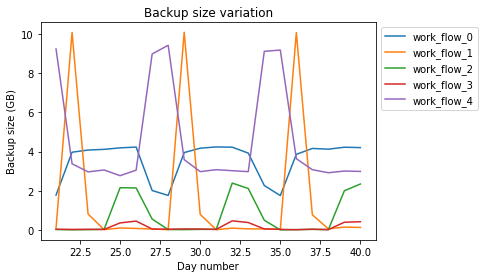

In [7]:
twenty = dataset.loc[dataset['Day #'] >= 21]
twenty = twenty.loc[twenty['Day #'] <= 40]
plot_dataset(twenty)

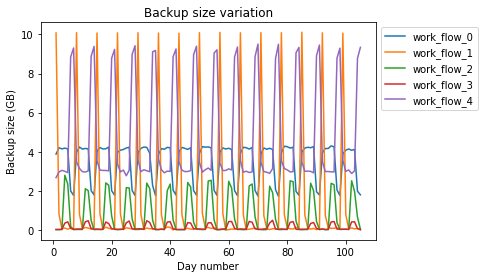

In [8]:
first105 = dataset.loc[dataset['Day #'] <= 105]
plot_dataset(first105)

<h2>Question 2</h2>

In [9]:
def encode_datalist(datalist):
    encoding = {}
    for i in datalist:
        if i in encoding:
            continue
        else:
            encoding[i] = i.split('_')[-1]
    return [encoding[i] for i in datalist]

In [10]:
dataset_copy = dataset.copy()

In [11]:
# dataset_copy contains scalar encoding of features
dataset_copy['Day of Week'] = encode_day_names(dataset_copy['Day of Week'])
dataset_copy['File Name'] = encode_datalist(dataset_copy['File Name'])
dataset_copy['Work-Flow-ID'] = encode_datalist(dataset_copy['Work-Flow-ID'])